In [1]:
from scipy import *
from numpy import *
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import io


In [2]:
## Load images
im=  io.imread('20211201_single-MNP_needle3_Pos9_2_exp100ms_spectraCyan100_MNPonGlass_1_MMStack_Pos0.ome_off0_nrmd_avg.tif')
mask=io.imread('20211201_single-MNP_needle3_Pos9_2_exp100ms_spectraCyan100_MNPonGlass_1_MMStack_Pos0.ome_mask.tif')

## Crop
im=  im  [200:680][:,:300]
mask=mask[200:680][:,:300]

## Fluorescence convertion (see notes)
im=im*0.13605


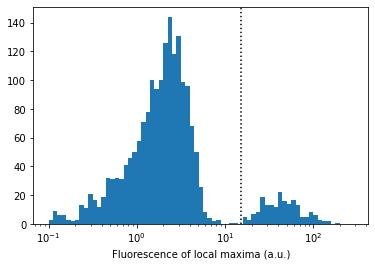

In [3]:
#### Select spots ####

sd1=1.; sd2=10.; cutoff=15;

## Compute band-passed image
imBp=ndimage.filters.gaussian_filter(im,sd1)-ndimage.filters.gaussian_filter(im,sd2)

## Find local maxima
imMax=(imBp>roll(imBp, 1,axis=0))*\
      (imBp>roll(imBp,-1,axis=0))*\
      (imBp>roll(imBp, 1,axis=1))*\
      (imBp>roll(imBp,-1,axis=1))*\
      (imBp>roll(roll(imBp, 1,axis=0), 1,axis=1))*\
      (imBp>roll(roll(imBp, 1,axis=0),-1,axis=1))*\
      (imBp>roll(roll(imBp,-1,axis=0),-1,axis=1))*\
      (imBp>roll(roll(imBp,-1,axis=0), 1,axis=1))*1

plt.figure();
plt.hist(imBp[where(imMax*mask)],bins=10**r_[-1:2.5:.05])
plt.axvline(cutoff,c='k',ls=':'); plt.xscale('log'); plt.xlabel('Fluorescence of local maxima (a.u.)')
plt.show()

imMax=imMax*(imBp>cutoff)*mask

<IPython.core.display.Javascript object>


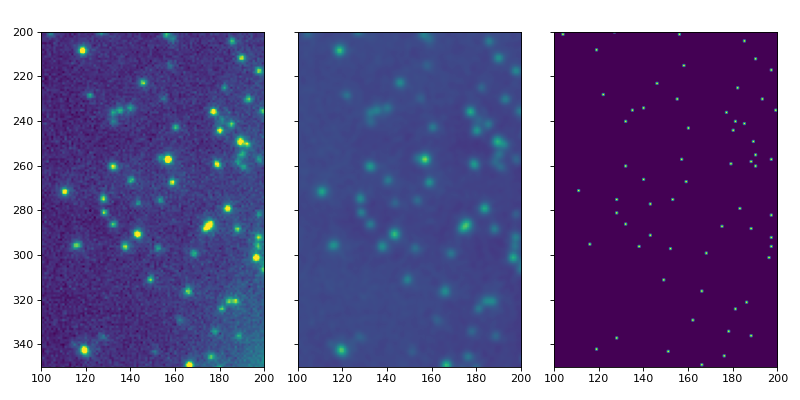

In [4]:
## Display
%matplotlib notebook
fig,ax=plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,5))
plt.sca(ax[0]); plt.imshow(im); plt.clim(-10,150)
plt.sca(ax[1]); plt.imshow(imBp); #plt.clim(0,100)
plt.sca(ax[2]); plt.imshow(imMax-mask*.1); #plt.clim(0,1)
plt.xlim(100,200); plt.ylim(350,200); 
plt.tight_layout()
plt.show()

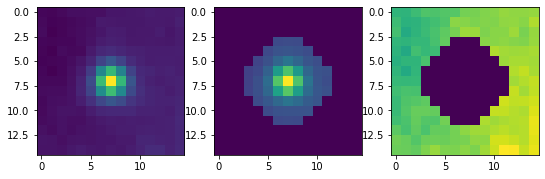

In [5]:
#### Define spot mask ####

r=4.2 # Radius of spot mask
w=7   # Size of window (half-width) around spots

## Make list of spot images
res=[]
for y,x in array(where(imMax)).T:
    res.append(roll(roll(im,-x+w,axis=1),-y+w,axis=0)[:1+2*w][:,:1+2*w])
res=array(res)

## Compute mean spot image
meanSpot=res.mean(0)

## Compute and display spot mask
spotMask=(lambda x,y: x**2+y**2<r**2)(*meshgrid(r_[-w:w+1],r_[-w:w+1]))*1.
wMask=where(spotMask)
wNotMask=where(1-spotMask)
%matplotlib inline
fig,ax=plt.subplots(1,3,figsize=(9,3))
plt.sca(ax[0]); plt.imshow(meanSpot)
plt.sca(ax[1]); plt.imshow(meanSpot*spotMask)
plt.sca(ax[2]); plt.imshow(meanSpot*(1-spotMask))
plt.show()

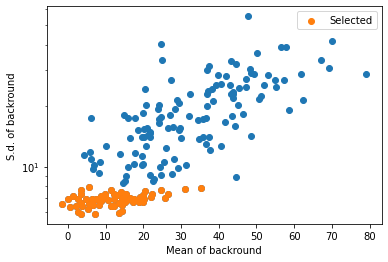

In [6]:
#### Select spots that are well isolated (i.e. where background is homogenous) ####

sdCutoff=8.

meanAndSDofBackground=array([[mean(a[wNotMask]), var(a[wNotMask])**.5] for a in res])
sel=where(meanAndSDofBackground[:,1]<sdCutoff)[0]
plt.figure()
plt.scatter(meanAndSDofBackground[:,0],   meanAndSDofBackground[:,1])
plt.scatter(meanAndSDofBackground[sel,0], meanAndSDofBackground[sel,1], label='Selected')
plt.yscale('log'); plt.legend()
plt.xlabel('Mean of backround'); plt.ylabel('S.d. of backround'); 
plt.show()

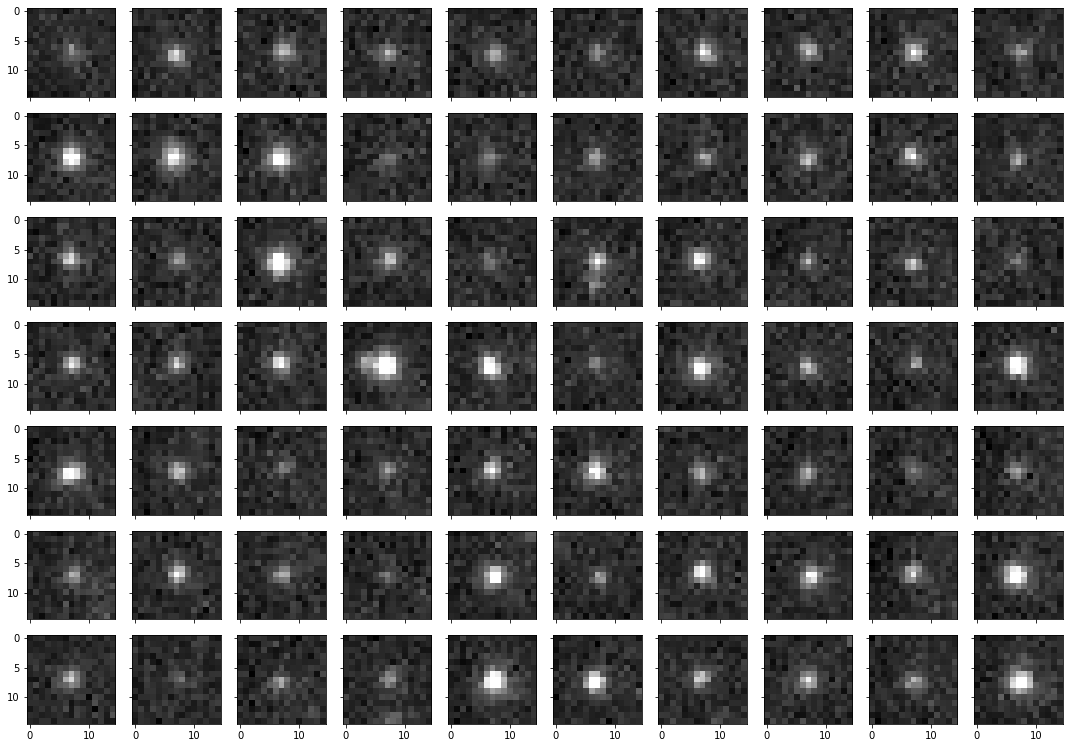

In [7]:
## Display spots for visual inspection
cols=10; rows=-(-sel.shape[0]//cols)
fig,ax=plt.subplots(rows,cols,sharex=True,sharey=True,figsize=(1.5*cols,1.5*rows))
ax_=ax.flatten()
for i,a in enumerate(res[sel][:ax_.shape[0]]):
    plt.sca(ax_[i])
    plt.imshow(a-median(a[wNotMask]),cmap='gray')
    plt.clim(-20,100)
plt.tight_layout()
plt.show()

In [8]:
#### Compute fluorescence of single MNPs ####

fluoMask=   array([   sum(a[wMask])    for a in res[sel]])                   # Summed ADUs in mask
fluoNotMask=array([median(a[wNotMask]) for a in res[sel]])*wMask[0].shape[0] # Estimated ADUs in mask coming from background

fluoSpots=fluoMask-fluoNotMask # Estimated ADUs coming from MNP

print("Spot intensity in 'standard' imaging conditions (exposure=100ms, SpectraX_Cyan=5, iXon_gain=30):")
print("  Mean:   %6.1f ADUs"%mean(fluoSpots))
print("  Median: %6.1f ADUs"%median(fluoSpots))

print("\nn = %d spots"%(fluoSpots.shape[0]))


Spot intensity in 'standard' imaging conditions (exposure=100ms, SpectraX_Cyan=5, iXon_gain=30):
  Mean:    900.3 ADUs
  Median:  747.5 ADUs

n = 70 spots
